# detecting polynomial classes from noisy data

The goal of this notebook is to interpret data in an x-y plane as a greyscale image. I want to use compare traditional MLPs with CNNs to classify unseen data and also check what happens if we confront the network with an unseen category of data. We go up to polynomials of degree 5 and randomly dice they coefficients. This can produce data that is pretty diverse.

## Training Data

The following function uses numpy to generate the data set. We make the output ndarray's shape configurable, but will stick with a 64x64 shaped plane that spans $x=(-32,32]$ or something alike.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def syn_image(x, values, yrange = None, shape = (32,32), value_span = (-1,1)):
    
    if type(yrange) == type(None):
        yrange = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
        
    current = np.zeros(shape)
    for ix in range(len(x)):
        yval = values[ix]
        xval = x[ix]
        if yval >= value_span[0] and yval <= value_span[-1]:
            yidx = len(x) -1 - np.searchsorted(yrange, yval, side="left")
            current[yidx,len(x) -1 - ix] = 1
            
    return current

def polynomials_as_images(size, max_degree, shape = (32,32), value_span = (-1,1), seed = 1, smear_sd = None):
    
    if seed:
        np.random.seed(seed)
        
    size = int(size)
    x = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[-1])
    y = np.linspace(start=value_span[0], stop=value_span[-1],num=shape[0])
    
    data   = np.zeros((size,int(shape[0]),int(shape[1])),
                       dtype=np.uint8)
    labels = np.random.randint(low=1,high=max_degree+1,size=size)
    
    for i in range(size):
        deg = labels[i]
        c   = np.random.random_sample(deg)
        #print(c)
        #print(x)
        values   = np.polynomial.polynomial.polyval(x,c)
        if smear_sd:
            smear_by = np.random.normal(1.,smear_sd,size=values.size)
            values = values*smear_by
        current = syn_image(x,values,y,shape,value_span)
            
        data[i,] = current
     
    return data, labels

In [2]:
train, labs = polynomials_as_images(20000,5,smear_sd=None)


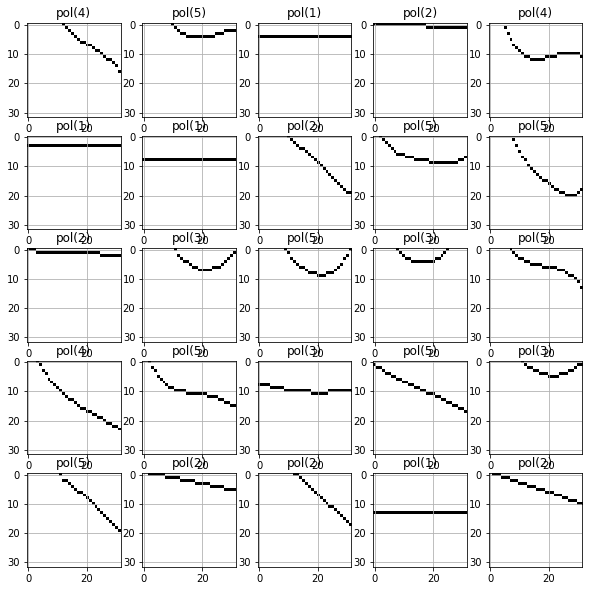

In [3]:
#nicer plots with axis labels etc
def plot_images(data, labels,  n_images = 25):
    xticks = np.linspace(start=1, stop=-1,num=3)
    yticks = np.linspace(start=1, stop=-1,num=3)

    plt.figure(figsize=(10,10))
    for i in range(n_images):
        ax = plt.subplot(5,5,i+1)
        #plt.xticks([])
        #plt.yticks([])
        plt.grid(True)
        plt.imshow(data[i], cmap=plt.cm.binary)
        #ax.xlabel("pol({0})".format(labs[i]),color='white')
        ax.set_title("pol({0})".format(labs[i]))
        
        
plot_images(train, labs)

In [4]:
#MLP comes here with non-linearity
from keras.utils import to_categorical
labels = to_categorical(labs)

from keras import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()
model.add(Flatten(input_shape=(32,32)))
model.add(Dense(64, activation='relu'))#all to all relation ship in first hidden layer
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

model.summary()



/Users/aimachine/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                65600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

hist = model.fit(train, labels, epochs=20,validation_split = .05)

Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 2s 85us/step - loss: 1.2675 - acc: 0.4017 - val_loss: 0.9839 - val_acc: 0.5650
Epoch 2/20
19000/19000 [==============================] - 1s 59us/step - loss: 0.9819 - acc: 0.5405 - val_loss: 0.8305 - val_acc: 0.6350
Epoch 3/20
19000/19000 [==============================] - 1s 61us/step - loss: 0.8633 - acc: 0.6046 - val_loss: 0.7609 - val_acc: 0.6560
Epoch 4/20
19000/19000 [==============================] - 1s 63us/step - loss: 0.8092 - acc: 0.6396 - val_loss: 0.7189 - val_acc: 0.6820
Epoch 5/20
19000/19000 [==============================] - 1s 65us/step - loss: 0.7633 - acc: 0.6666 - val_loss: 0.7140 - val_acc: 0.6760
Epoch 6/20
19000/19000 [==============================] - 1s 64us/step - loss: 0.7311 - acc: 0.6845 - val_loss: 0.6909 - val_acc: 0.6990
Epoch 7/20
19000/19000 [==============================] - 1s 64us/step - loss: 0.7009 - acc: 0.7022 - val_loss: 0.6825 - val_acc:

In [6]:
#CNN
from keras.layers import Conv2D, MaxPooling2D

train_ = train.reshape(train.shape[0],train.shape[1],train.shape[2],1)

cnn = Sequential()
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(32,32,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.2))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(6, activation='softmax'))

cnn.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
__________

In [7]:
cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy']
             )

chist = cnn.fit(train_, labels, epochs=20,
                  validation_split = .05)

Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 15s 811us/step - loss: 0.9613 - acc: 0.5652 - val_loss: 0.7020 - val_acc: 0.7050
Epoch 2/20
19000/19000 [==============================] - 14s 741us/step - loss: 0.6972 - acc: 0.6990 - val_loss: 0.6178 - val_acc: 0.7460
Epoch 3/20
19000/19000 [==============================] - 14s 757us/step - loss: 0.6346 - acc: 0.7306 - val_loss: 0.5809 - val_acc: 0.7680
Epoch 4/20
19000/19000 [==============================] - 15s 781us/step - loss: 0.5966 - acc: 0.7550 - val_loss: 0.5390 - val_acc: 0.7940
Epoch 5/20
19000/19000 [==============================] - 15s 806us/step - loss: 0.5752 - acc: 0.7646 - val_loss: 0.5374 - val_acc: 0.8010
Epoch 6/20
19000/19000 [==============================] - 15s 782us/step - loss: 0.5547 - acc: 0.7761 - val_loss: 0.5227 - val_acc: 0.8170
Epoch 7/20
19000/19000 [==============================] - 16s 822us/step - loss: 0.5397 - acc: 0.7817 - val_loss: 0.5

In [8]:
def plot_loss_acc(hist):
    fig = plt.figure(figsize=(15,4));
  
    ax = fig.add_subplot(121)
    ax.semilogy(hist.epoch,hist.history['loss'],hist.history['val_loss'])
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(['train','val/test'],loc='upper right')
    ax.grid(True)

    ax = fig.add_subplot(122)
    ax.plot(hist.epoch,hist.history['acc'],hist.history['val_acc'])
    ax.set_ylim([0.,1.])
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    ax.legend(['train','val/test'],loc='lower right')
    ax.grid(True)

MLP
ConvNet


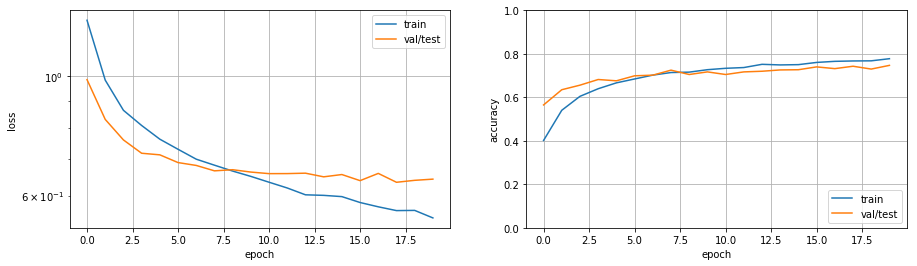

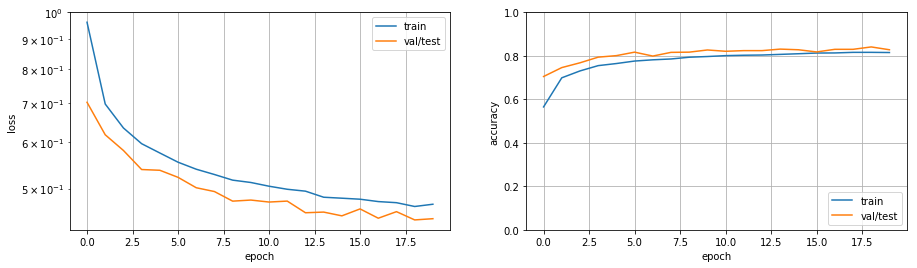

In [9]:
print("MLP")
plot_loss_acc(hist)
print("ConvNet")
plot_loss_acc(chist)

## 